#### Importing neccessary libraries

1. **Numpy** for *linear algebra*
2. **Pandas** for reading csv files and DataFrame handling
3. **Tensorflow** for *machine learning*
4. **Keras** for defining the *LSTM model architecture* and regularization
5. Functions such as **train_test_split** for dividing the dataset into training and test set and **GridSearchCV** to tune hyperparameters across a grid of values.
6. **MinMaxScaler** to scale the variable values to a range of $[0,1]$.  
7. **matplotlib** for plotting results
8. **logging** for errors.

In [81]:
pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 41.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Input
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from scikeras.wrappers import KerasClassifier
from itertools import product
import matplotlib.pyplot as plt
import logging

Configuration of logging:

In [2]:
logging.basicConfig(level = logging.INFO, format = '%(asctime)s - %(levelname)s - %(message)s')

Since the model is run in Google Colab with an external GPU for increased computational ability the device which is used needs to be defined:

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    logging.warning('GPU device not found. Use CPU instead')
else:
    logging.info(f'Found GPU at: {device_name}')

In [4]:
logging.info('Loading dataset...')

file_path = '/content/final_dataset.csv'
df = pd.read_csv(file_path)
dataset = df.values[:, 1:].astype('float64') # Later this can be changed to float64 for further precision.

diff = dataset[:,:1]

In [5]:
# Define a function to categorize the percent change
# Values for (25,75) and (40,60) percentiles are listed below. Both will be tested.
#25th: -0.0037000000000000366
#75th: 0.003649999999999931
#40th: -0.0012000000000000899
#60th: 0.0013000000000000789
def categorize_diff(diff):
    if diff < -0.0012000000000000899:
        return 0  # Price falls
    elif diff > 0.0013000000000000789:
        return 2  # Price rises
    else:
        return 1  # Price stays the same

# Apply the function to y_diff to get the categories
logging.info('Categorizing percent change...')
y_categories = np.array([categorize_diff(pc) for pc in diff])

# Normalizing dataset
logging.info('Normalizing dataset...')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset[:, 1:])


In [6]:
def create_dataset(dataset, time_steps=1):
    dataX = []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), :]
        dataX.append(a)
    return np.array(dataX)

In [7]:
time_steps = 20

dataX = create_dataset(dataset, time_steps)

dataX = np.reshape(dataX, (dataX.shape[0], time_steps, dataset.shape[1]))

X = dataX
y = y_categories[time_steps:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [8]:
def create_model(units=64, dropout_rate=0.2, batch_size = 32):
    model = Sequential([
        Input(shape=(X.shape[1], X.shape[2])),  # Explicitly define the input shape
        LSTM(units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def create_advanced_model(units=64, dropout_rate=0.2, batch_size = 32):
    model = Sequential([
        Input(shape=(X.shape[1], X.shape[2])),  # Explicitly define the input shape
        LSTM(units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [9]:
model = KerasClassifier(model=create_model, epochs = 100, verbose=0)

In [10]:
param_grid = {
    'model__units': [32, 64, 128],
    'model__dropout_rate': [0.1, 0.2, 0.3, 0,4],
    'batch_size': [32, 64, 128]
}

In [11]:
# Perform Grid Search with 5-fold cross-validation
logging.info('Starting grid search...')
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs = -1)

In [12]:
# Fit the grid search
grid_result = grid.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
45 fits failed out of a total of 225.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following erro

In [35]:
best_params = grid_result.best_params_
logging.info(f"Best Parameters: {best_params}")
print(best_params)

{'batch_size': 32, 'model__dropout_rate': 0.3, 'model__units': 128}


In [28]:
best_model = create_model(units=best_params['model__units'],
                          dropout_rate=best_params['model__dropout_rate'],
                          batch_size = best_params['batch_size']
                          )


In [29]:
history = best_model.fit(X_train, y_train,
                         epochs=100,  # Set this to the desired number of epochs
                         batch_size=best_params['batch_size'],
                         validation_data=(X_test, y_test),
                         verbose=1)


Epoch 1/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3890 - loss: 1.0646 - val_accuracy: 0.3850 - val_loss: 1.0685
Epoch 2/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3989 - loss: 1.0594 - val_accuracy: 0.3914 - val_loss: 1.0720
Epoch 3/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3956 - loss: 1.0647 - val_accuracy: 0.3914 - val_loss: 1.0763
Epoch 4/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4079 - loss: 1.0533 - val_accuracy: 0.3914 - val_loss: 1.0833
Epoch 5/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3912 - loss: 1.0522 - val_accuracy: 0.3850 - val_loss: 1.0724
Epoch 6/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3968 - loss: 1.0452 - val_accuracy: 0.3945 - val_loss: 1.0678
Epoch 7/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4173 - loss: 1.0447 - val_accuracy: 0.3914 - val_loss: 1.0706
Epoch 8/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4001 - loss: 1.0515 - val_accu

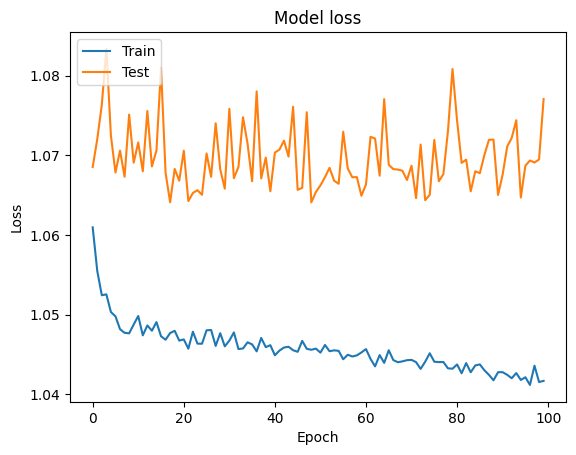

In [30]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [32]:
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 128)                 │          79,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 240,779 (940.55 KB)

 Trainable params: 80,259 (313.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 160,520 (627.04 KB)

In [34]:
model_save_path = 'first_iteration_lstm.keras' # time steps = 20, epochs = 100, 1 hidden layer, 0.3 dropout rate, 32 batch size,
best_model.save(model_save_path)
logging.info(f"Model saved to {model_save_path}")


In [36]:
loaded_model = tf.keras.models.load_model(model_save_path)
loaded_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 128)                 │          79,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 160,520 (627.04 KB)

 Trainable params: 80,259 (313.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 80,261 (313.52 KB)

SECOND MODEL

In [8]:
time_steps = 10

In [9]:
def create_model(units=64, dropout_rate=0.2, batch_size = 32):
    model = Sequential([
        Input(shape=(X.shape[1], X.shape[2])),  # Explicitly define the input shape
        LSTM(units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
model = KerasClassifier(model=create_model, epochs = 100, verbose=0)

In [11]:
param_grid = {
    'model__units': [32, 64, 128],
    'model__dropout_rate': [0.1, 0.2, 0.3, 0,4],
    'batch_size': [32, 64, 128]
}

In [12]:
# Perform Grid Search with 5-fold cross-validation
logging.info('Starting grid search...')
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

In [ ]:
# Fit the grid search
grid_result = grid.fit(X_train, y_train)

In [ ]:
time_steps = 30

In [ ]:
def create_model(units=64, dropout_rate=0.2, batch_size = 32):
    model = Sequential([
        Input(shape=(X.shape[1], X.shape[2])),  # Explicitly define the input shape
        LSTM(units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = KerasClassifier(model=create_model, epochs = 100, verbose=0)

In [ ]:
param_grid = {
    'model__units': [32, 64, 128],
    'model__dropout_rate': [0.1, 0.2, 0.3, 0,4],
    'batch_size': [32, 64, 128]
}

In [ ]:
# Perform Grid Search with 5-fold cross-validation
logging.info('Starting grid search...')
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

In [ ]:
# Fit the grid search
grid_result = grid.fit(X_train, y_train)